In [1]:
dataset <- "ARPAL"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Liguria"
match_dist <- 15000
new_dataset <- "LIG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    filter(!(sensor_key == 3546L & dataset == "SCIA")) |> # Removing SARZANA bad data
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 10000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Emilia-Romagna", "Toscana"), network != "DPC")
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    tag_mergeable() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 30L, 0.5, ignore_corrections)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
34,3.6073033,-0.7355841,-0.1811064922,-0.012187244,38,49,412,1,0,COLLE DEL MELOGNO,ARPAL,49,SETTEPANI,Idrografica,3601
64,-1.6480974,-0.6789848,0.2106169024,0.060691004,75,99,330,-1,0,LOCO CARCHELLI,ARPAL,99,Loco Carchelli,Idrografica,1997
33,2.6702186,-1.6319704,0.0910987151,-0.008580826,38,49,412,-1,0,COLLE DEL MELOGNO,ARPAL,49,SETTEPANI,Idrografica,3601
8,2.2497099,-1.1302014,0.0009723933,-0.518659665,4,5,200,1,0,ALBENGA - MOLINO BRANCA,ARPAL,5,Albenga,Idrografica,164
65,-0.6838009,-1.2354369,0.2238402919,-0.057992236,75,99,330,1,0,LOCO CARCHELLI,ARPAL,99,Loco Carchelli,Idrografica,1997
2,1.3918367,0.0000000,0.0000000000,0.000000000,1,2,1,1,0,AIROLE,ARPAL,2,AIROLE,ARPAL,1
7,-1.4102167,0.2575661,0.1747467549,-0.825194881,4,5,200,-1,0,ALBENGA - MOLINO BRANCA,ARPAL,5,Albenga,Idrografica,164
256,-0.7831633,-0.2578482,-0.0378787233,0.158925205,128,165,166,1,0,STATALE,ARPAL,165,STATALE,ARPAL,166
1,-0.8463576,0.0000000,0.0000000000,0.000000000,1,2,1,-1,0,AIROLE,ARPAL,2,AIROLE,ARPAL,1


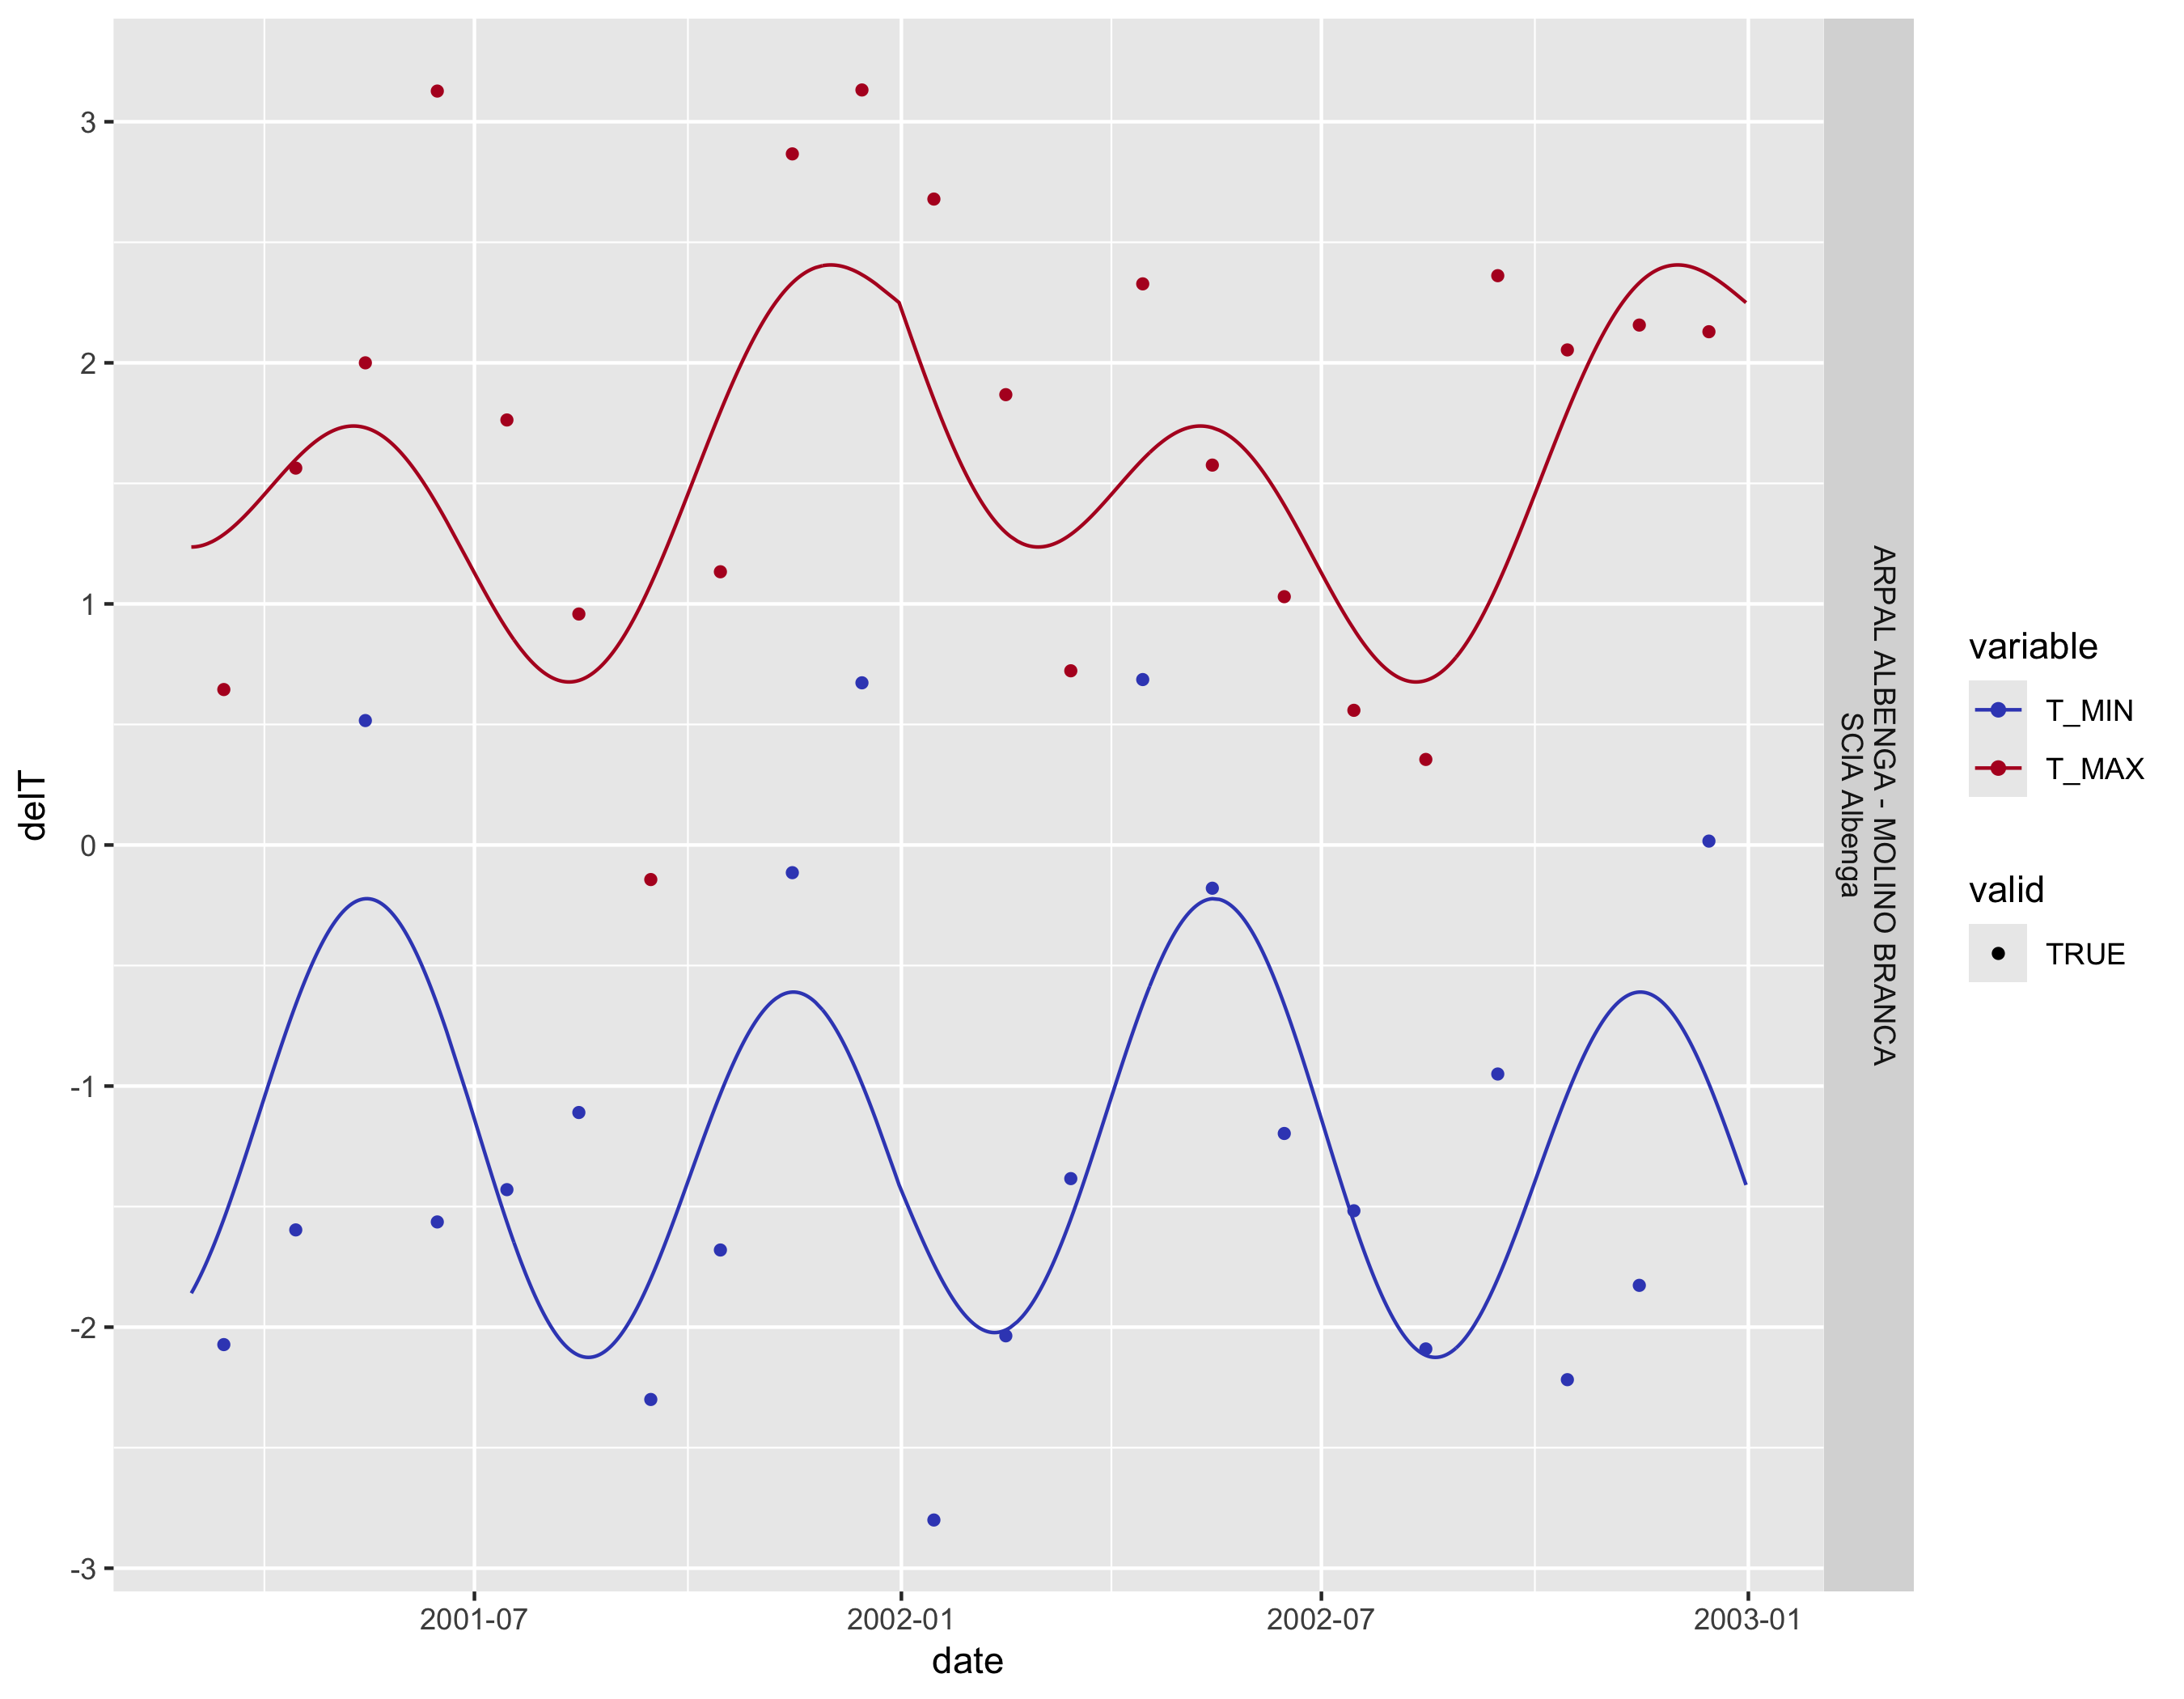

In [14]:
i |> filter(gkey == 4L) |> plot_correction(metadata, data)

In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2192241,117.1,5816375,310.7,NA,4511125,241.0
Vcells,24037645,183.4,82678449,630.8,16384,129180924,985.6


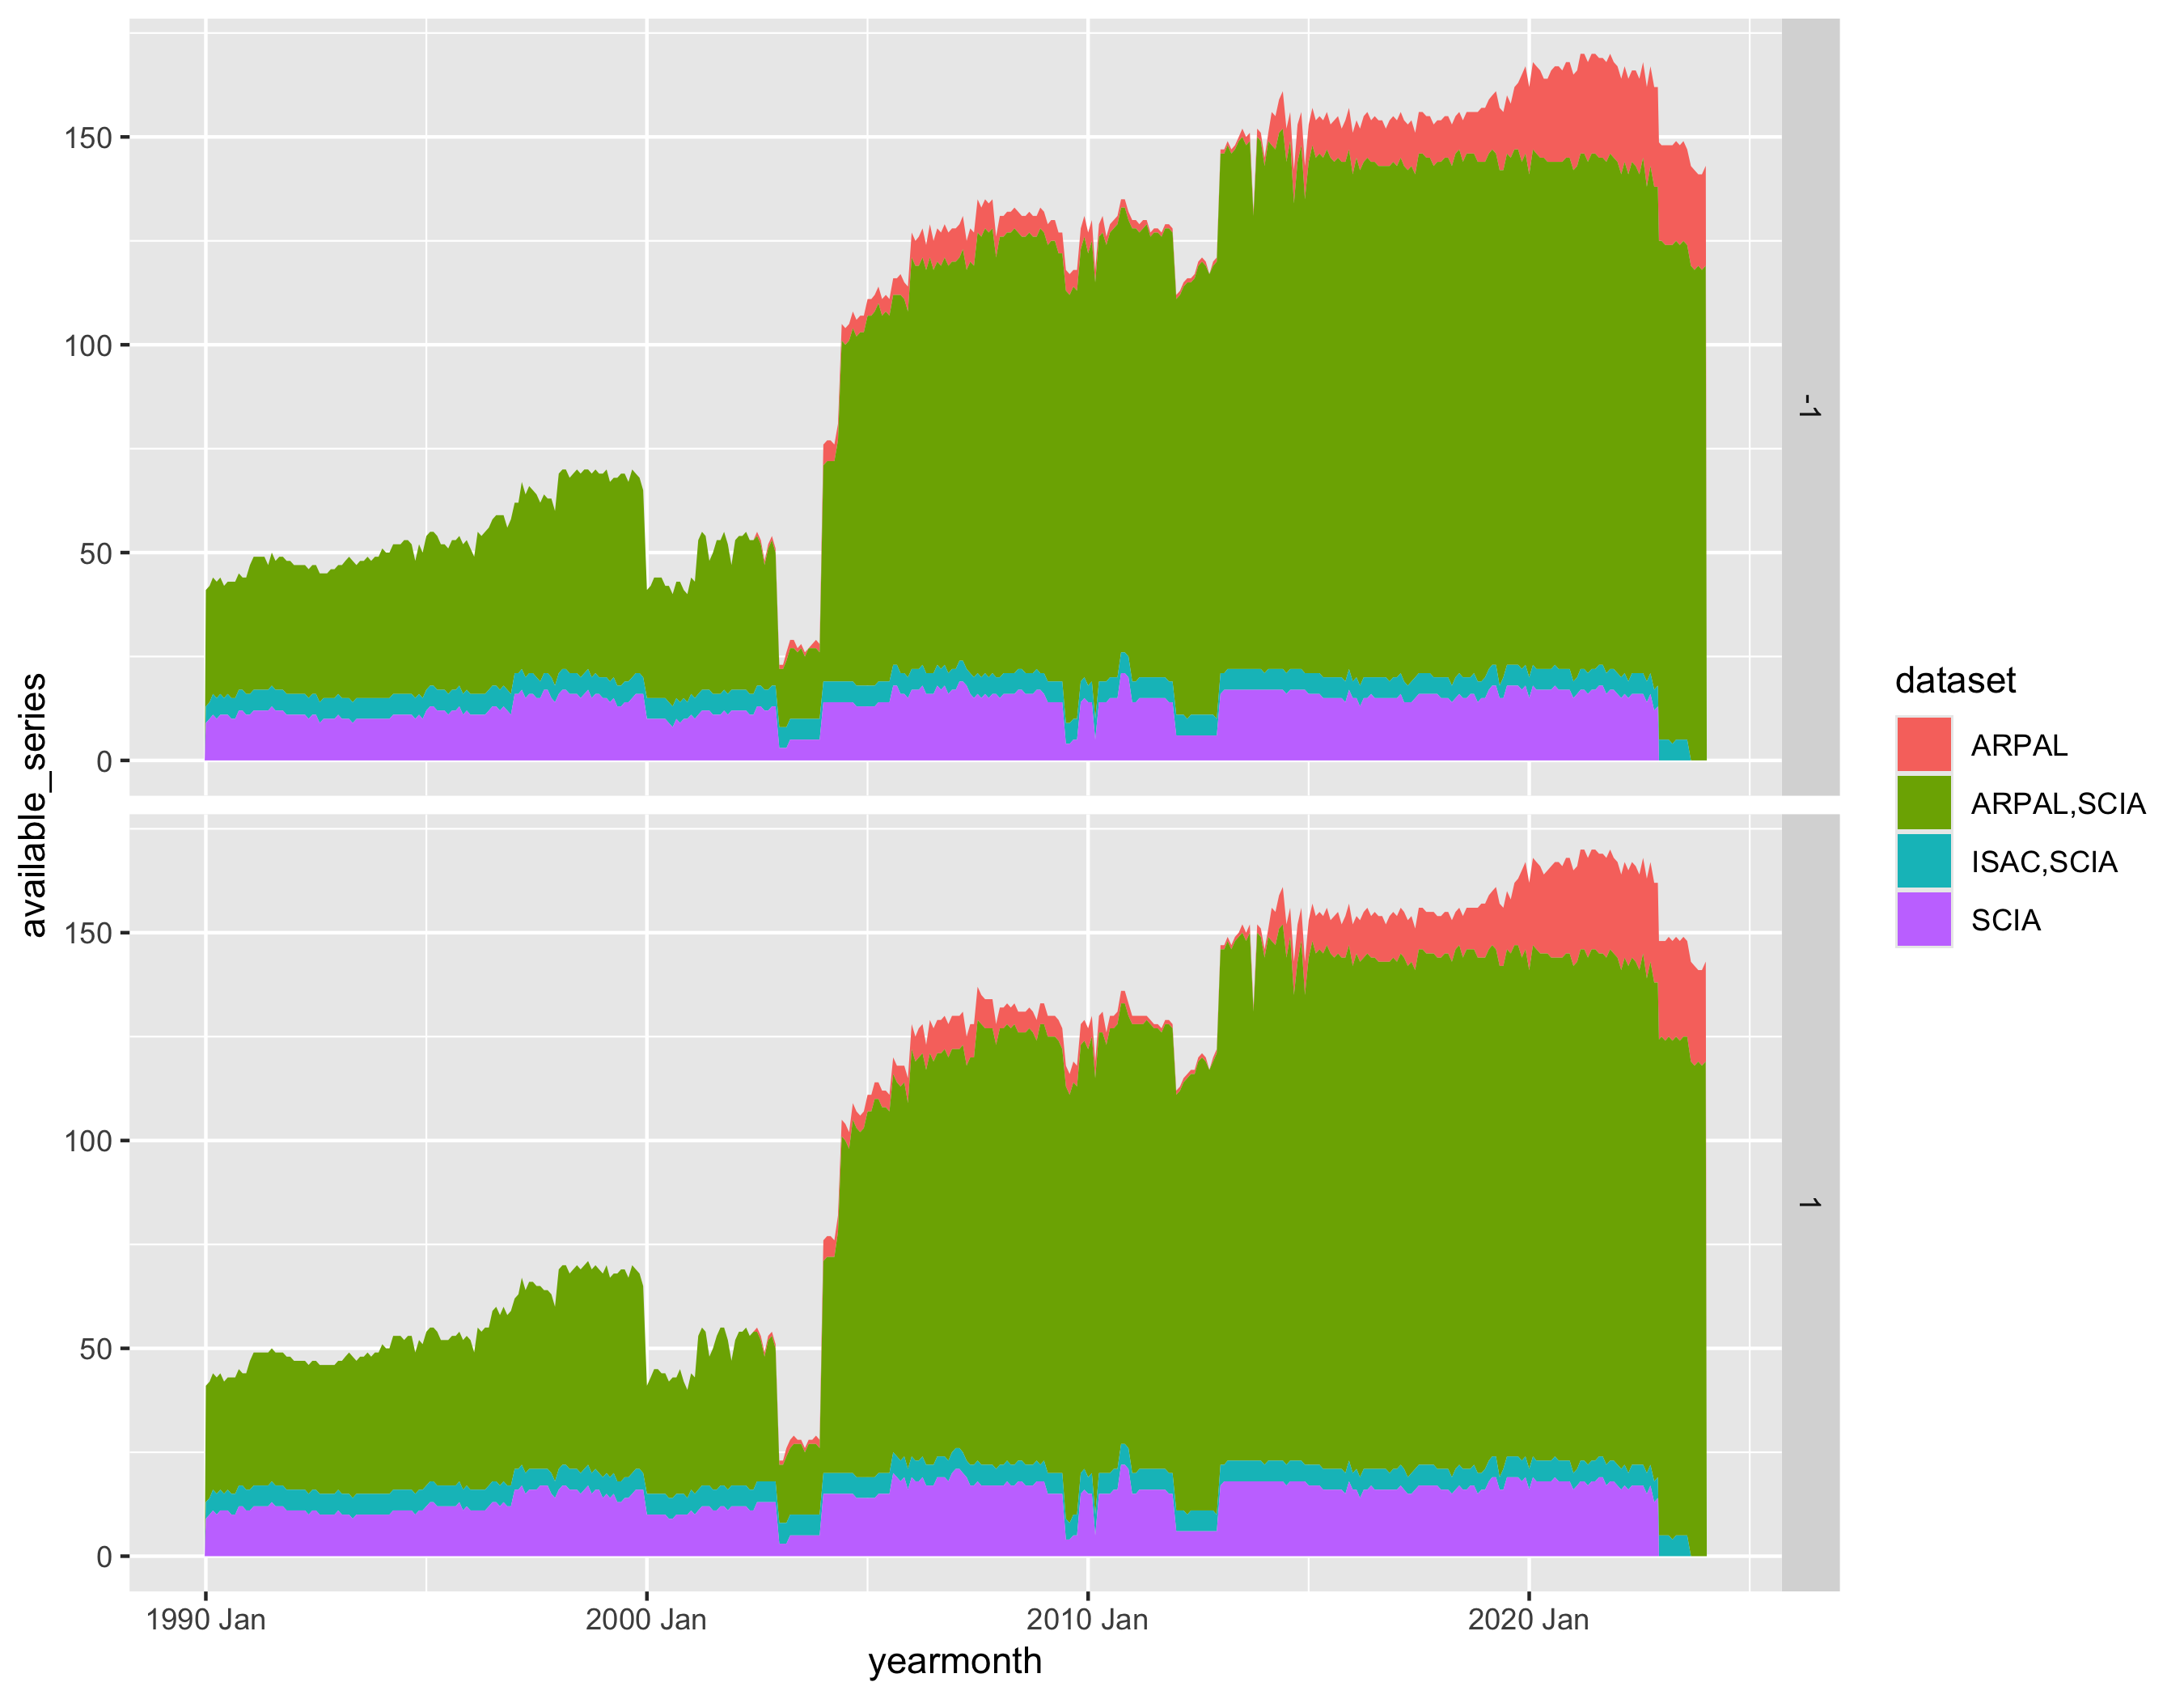

In [16]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


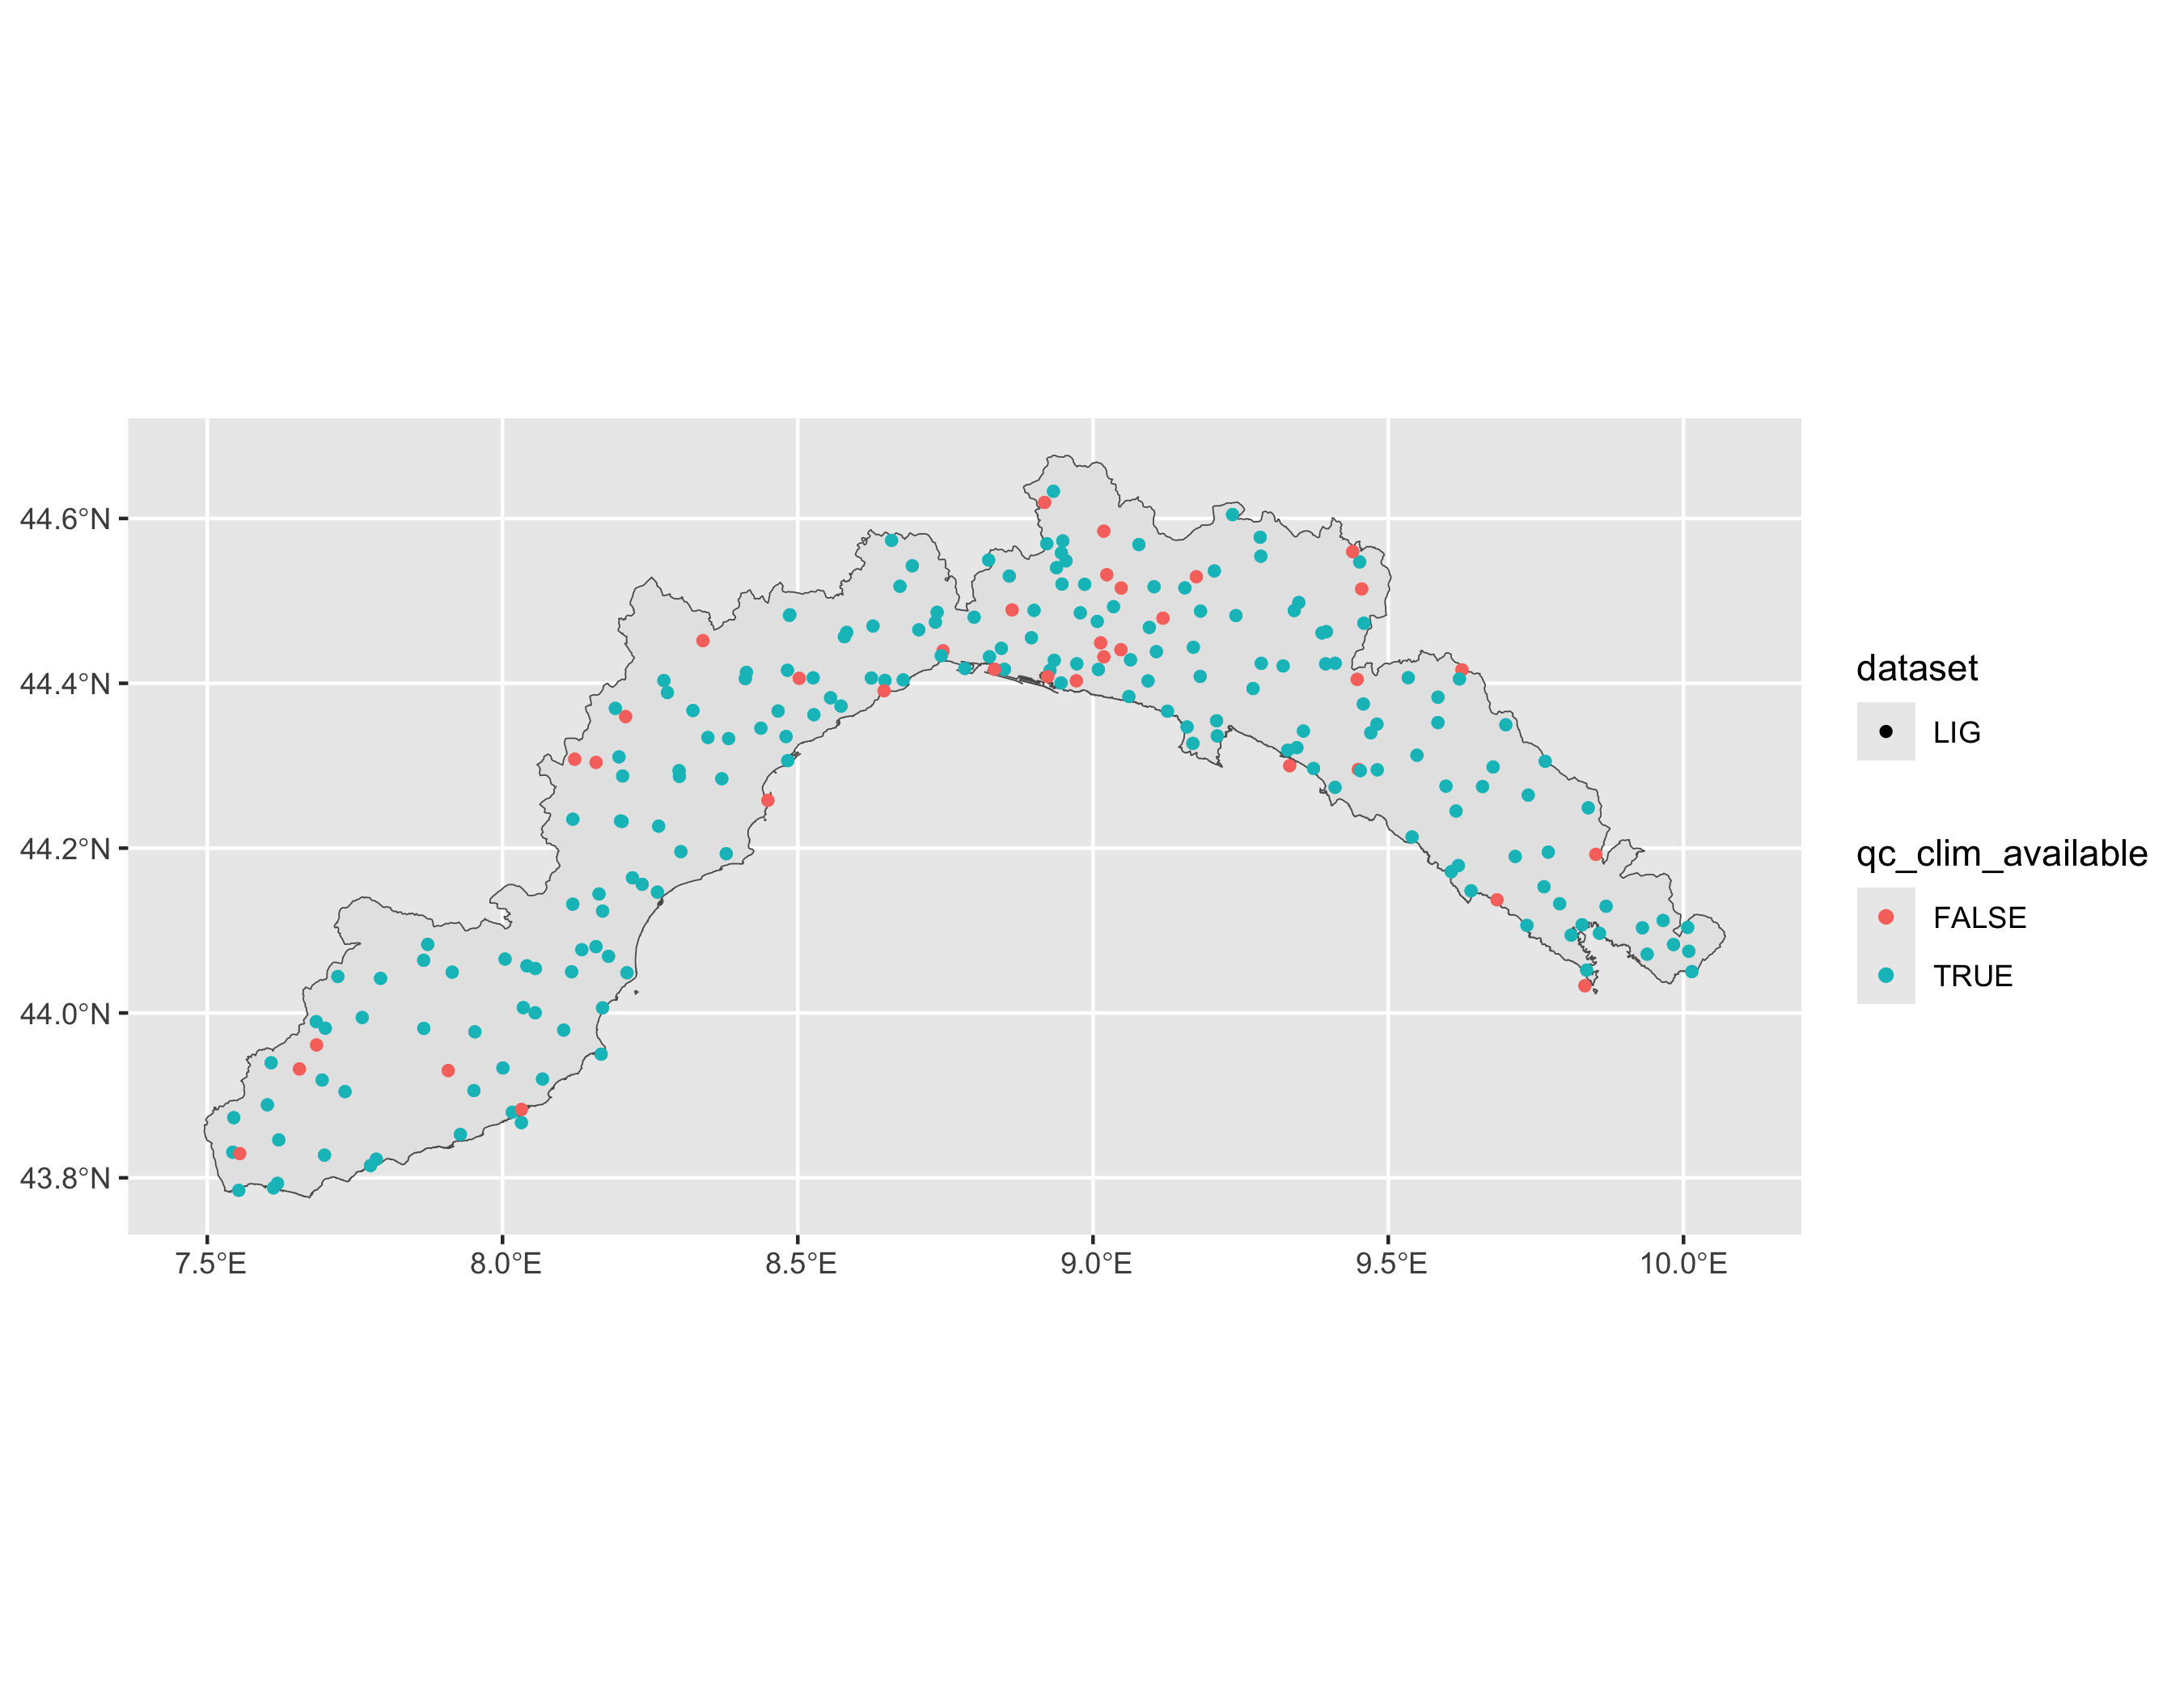

In [17]:
sp_data <- pd$data |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot
